In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def add_coords_to_img(img_arr: np.array, coords: np.array) -> Image:
    layers_map = {
        1: 'L',
        3: 'RGB',
        4: 'RGBA'
    }
    layer_count = img_arr.shape[2] if len(img_arr.shape) == 3 else 1
    image = Image.fromarray(img_arr.astype('uint8'), layers_map[layer_count])
    draw = ImageDraw.Draw(image)
    for point in coords:
        px = point.item(0)
        py = point.item(1)
        d = img_arr.shape[0] * 0.015
        draw.ellipse((px - d, py - d, px + d, py + d), fill="red")
    return image

In [3]:
ROWS = int(64 / 4)
COLS = 4
COUNT = ROWS * COLS

# Load train dataset

In [4]:
values = [
    np.array(Image.open(f"data/trainset_128/{i:0>7}.png"), dtype=np.uint8)
    for i in range(COUNT)
]

In [5]:
coords_path = "data/trainset_128/coords.csv"
all_coords = np.loadtxt(open(coords_path, "rb"), delimiter=",").astype(dtype=np.float32)
labels = [np.resize(all_coords[i], (4,2)) for i in range(COUNT)]

# Look at train images

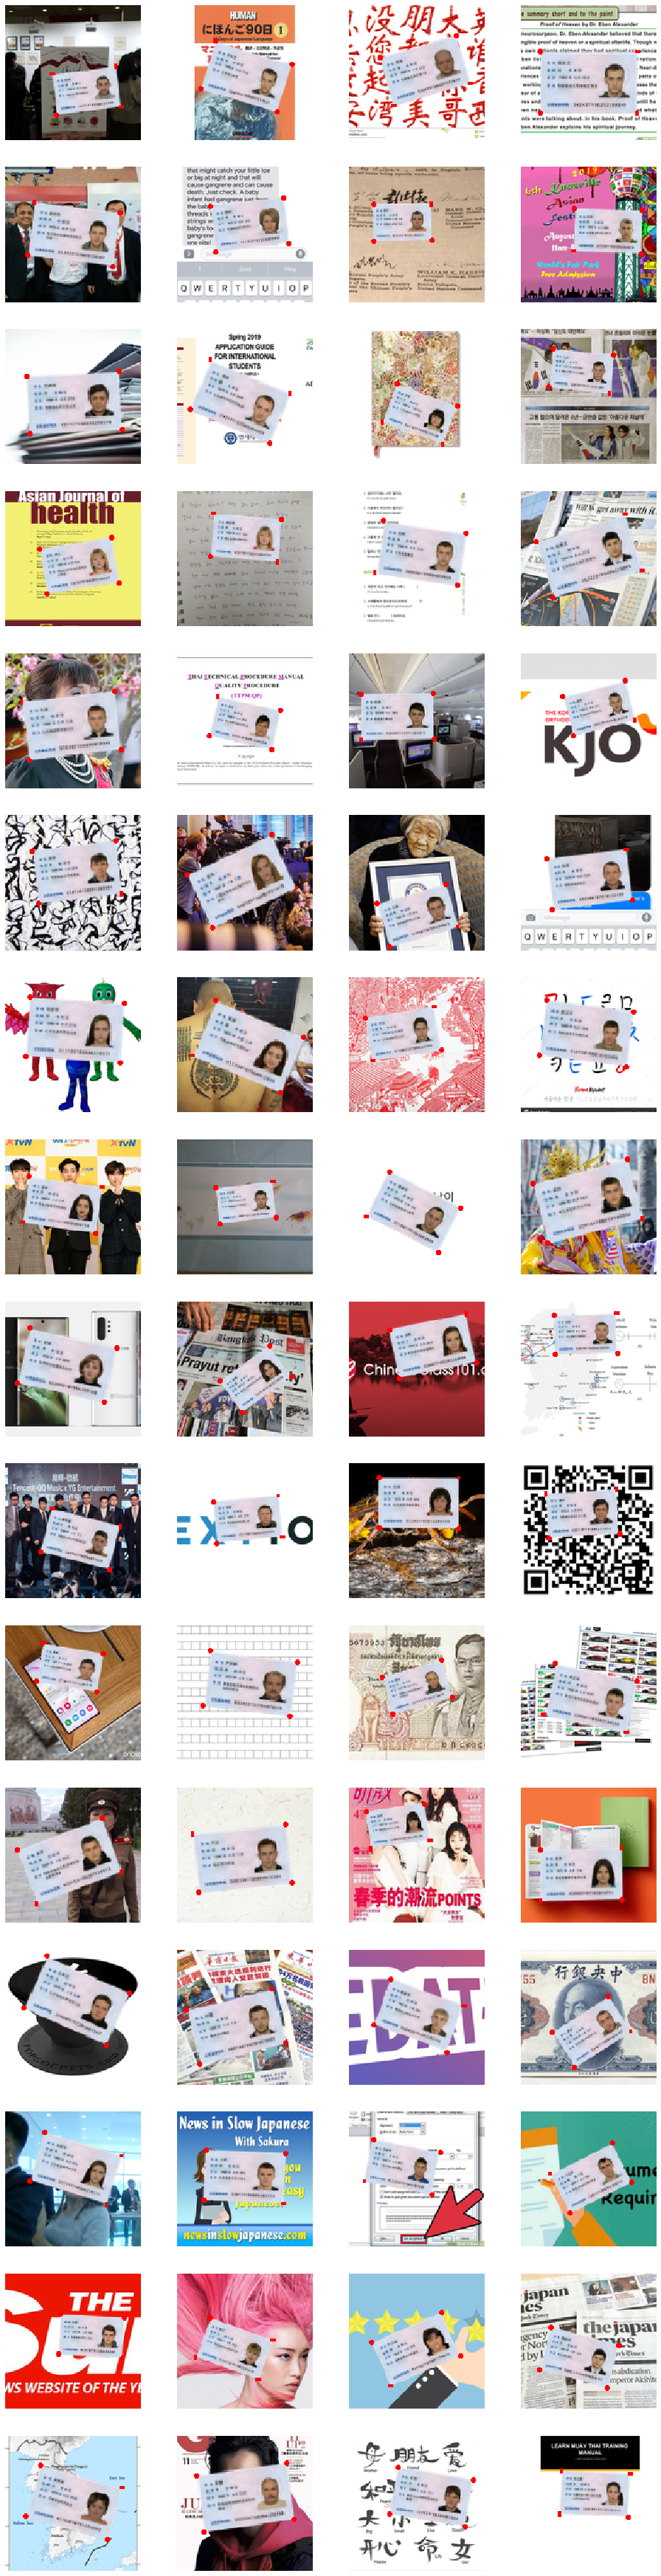

In [6]:
fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
for i in range(ROWS):
    for j in range(COLS):
        card, coords = values[i*COLS + j], labels[i*COLS + j]
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card, coords));

# Look at prediction

In [7]:
import torch
from torchvision import models
from torch import nn, optim, cuda
from torchvision.transforms import transforms

# Load model

In [8]:
MODEL_PATH = './data/weights/resnet50_regression_v2.2.3.pt'
NUM_CLASSES = 8

In [9]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

# Load train samples

In [10]:
to_tensor = transforms.ToTensor()
net_values = [
    to_tensor(
        np.array(Image.open(f"data/trainset_128/{i:0>7}.png"), dtype=np.uint8)
    ).unsqueeze(0)
    for i in range(64)
]

In [11]:
all_net_values = torch.cat(net_values, 0)

# predict

In [12]:
%%time
coords = model(all_net_values)
predict_coords = torch.split(coords, 1, dim=1)

CPU times: user 3.51 s, sys: 738 ms, total: 4.25 s
Wall time: 2.21 s


In [13]:
all_predict_coords = torch.cat(predict_coords, 1)

In [14]:
all_predict_coords_np = all_predict_coords.cpu().detach().numpy()

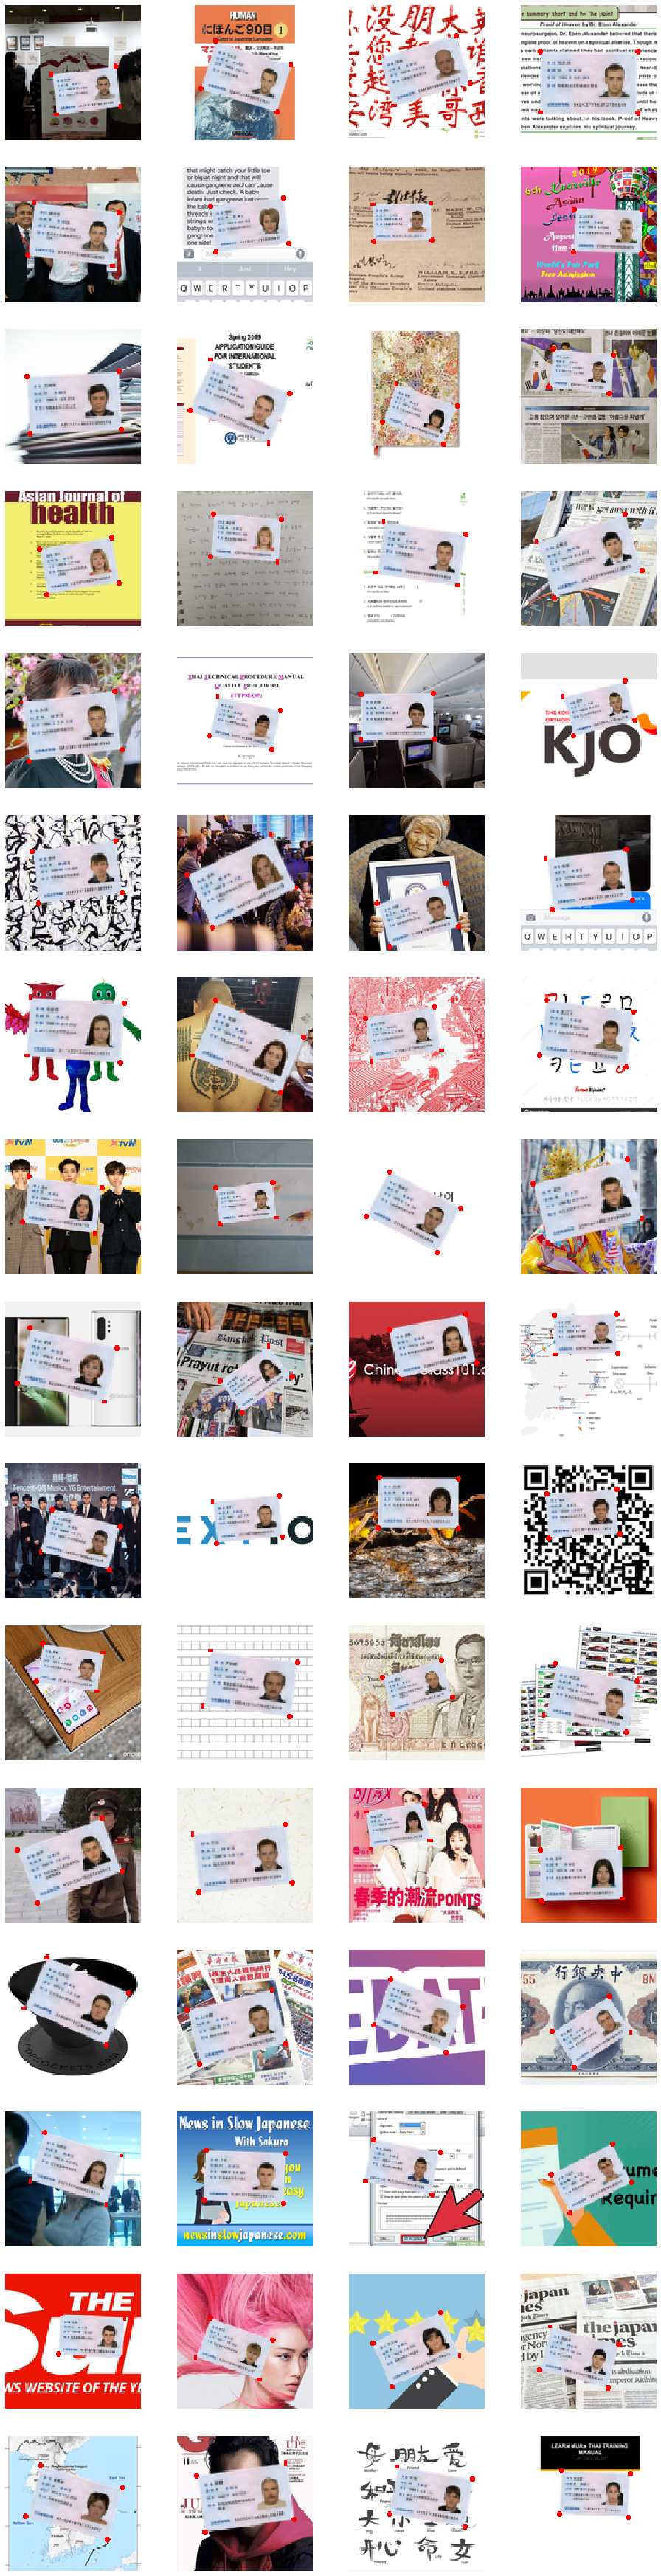

In [15]:
fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
for i in range(ROWS):
    for j in range(COLS):
        index = i * COLS + j
        card = values[index]
        coords = np.resize(all_predict_coords_np[index], (4,2))
        axes[i, j].set_axis_off()
        axes[i, j].imshow(add_coords_to_img(card, coords));